In [64]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [65]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../../Dataset/ADBE_Stock.csv')
df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,ADBE,264.010010,264.010010,266.239990,261.500000,265.750000,2594000
1,3/4/2019,ADBE,258.160004,258.160004,267.000000,254.080002,266.700012,2994900
2,3/5/2019,ADBE,257.380005,257.380005,259.869995,256.369995,259.000000,2101800
3,3/6/2019,ADBE,256.399994,256.399994,259.489990,253.839996,257.399994,1950500
4,3/7/2019,ADBE,255.460007,255.460007,257.489990,253.289993,255.770004,3185200
...,...,...,...,...,...,...,...,...
1319,5/28/2024,ADBE,478.429993,478.429993,478.670013,469.600006,473.010010,2575300
1320,5/29/2024,ADBE,477.600006,477.600006,482.790008,472.600006,472.779999,2214800
1321,5/30/2024,ADBE,445.869995,445.869995,466.820007,444.839996,464.899994,5606900
1322,5/31/2024,ADBE,444.760010,444.760010,448.230011,433.970001,447.720001,7487500


In [66]:
df.describe

<bound method NDFrame.describe of            Date Symbol   Adj Close       Close        High         Low  \
0      3/1/2019   ADBE  264.010010  264.010010  266.239990  261.500000   
1      3/4/2019   ADBE  258.160004  258.160004  267.000000  254.080002   
2      3/5/2019   ADBE  257.380005  257.380005  259.869995  256.369995   
3      3/6/2019   ADBE  256.399994  256.399994  259.489990  253.839996   
4      3/7/2019   ADBE  255.460007  255.460007  257.489990  253.289993   
...         ...    ...         ...         ...         ...         ...   
1319  5/28/2024   ADBE  478.429993  478.429993  478.670013  469.600006   
1320  5/29/2024   ADBE  477.600006  477.600006  482.790008  472.600006   
1321  5/30/2024   ADBE  445.869995  445.869995  466.820007  444.839996   
1322  5/31/2024   ADBE  444.760010  444.760010  448.230011  433.970001   
1323   6/3/2024   ADBE  439.019989  439.019989  449.839996  436.579987   

            Open   Volume  
0     265.750000  2594000  
1     266.700012  299

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [68]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [69]:
detect_outlier(df, 'Close')

Empty DataFrame
Columns: [Date, Symbol, Adj Close, Close, High, Low, Open, Volume]
Index: []


In [70]:
df1=df.reset_index()['Close']

In [71]:
df1

0       264.010010
1       258.160004
2       257.380005
3       256.399994
4       255.460007
           ...    
1319    478.429993
1320    477.600006
1321    445.869995
1322    444.760010
1323    439.019989
Name: Close, Length: 1324, dtype: float64

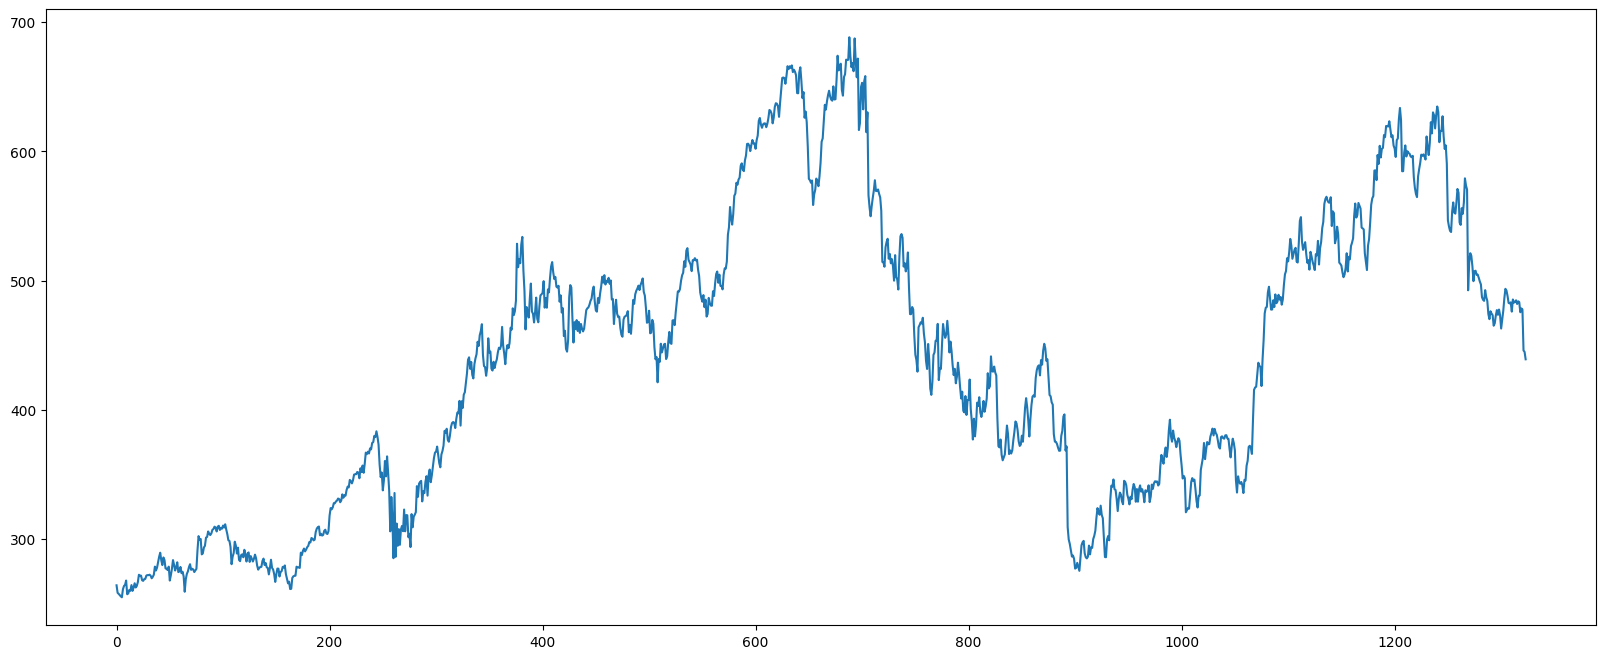

In [72]:
plt.figure(figsize=(20, 8))
plt.plot(df1)
plt.show()

In [73]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [74]:
df1

array([[0.02137768],
       [0.0078869 ],
       [0.00608814],
       ...,
       [0.44076746],
       [0.43820771],
       [0.42497057]])

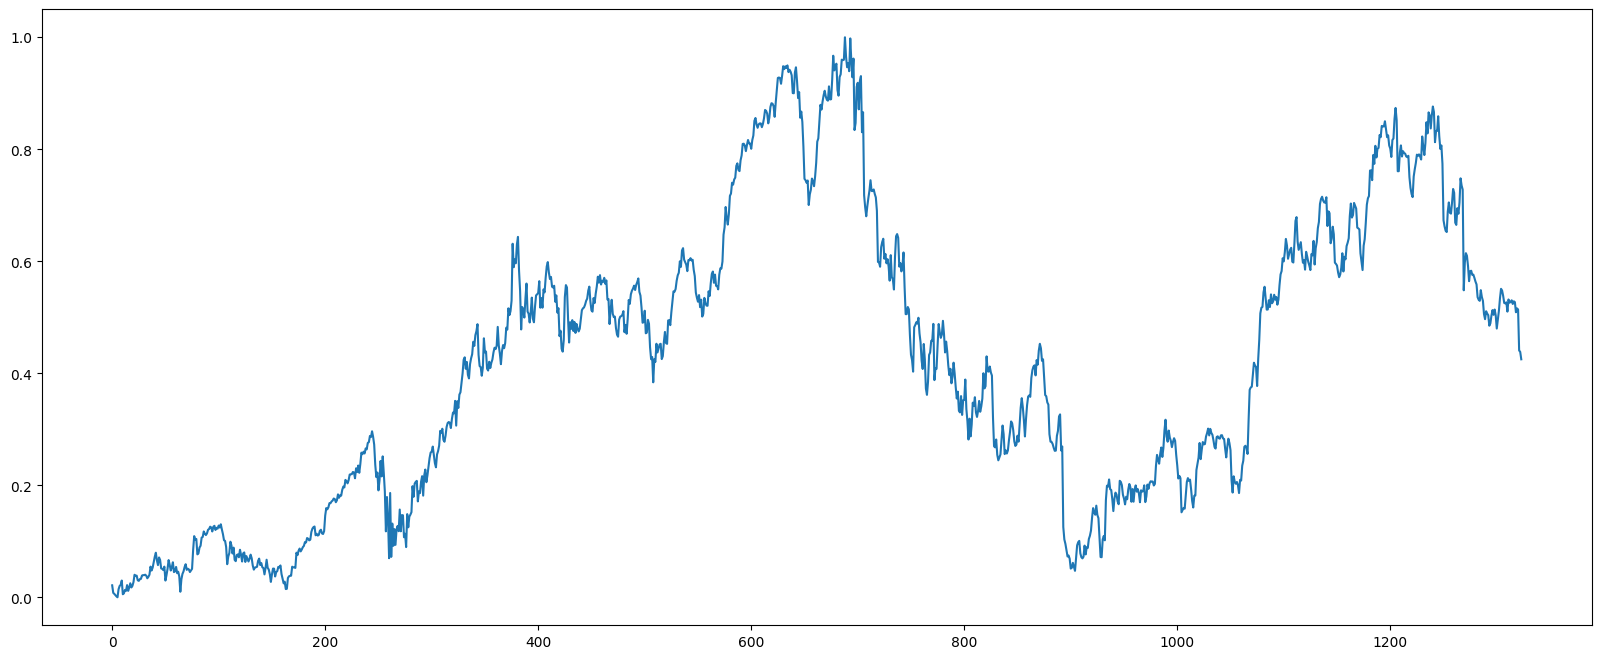

In [75]:
plt.figure(figsize=(20, 8))
plt.plot(df1)
plt.show()

In [76]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [77]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [78]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [79]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [80]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [81]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 97ms/step - loss: 0.1008 - val_loss: 0.0081
Epoch 2/100
13/13 [==============================] - 1s 60ms/step - loss: 0.0176 - val_loss: 0.0035
Epoch 3/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 4/100
13/13 [==============================] - 1s 51ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 5/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 6/100
13/13 [==============================] - 1s 51ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
13/13 [==============================] - 1s 48ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/100
13/13 [==============================] - 1s 51ms/step - loss: 0.0010 - val_loss: 0.0011

In [82]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 15ms/step


In [83]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
# y_pred_val=scaler.inverse_transform(y_pred_val)

In [84]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mape = calculate_mape(ytest, y_pred)
test_mae = calculate_mae(ytest, y_pred)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 11.288320742261197
Testing MAPE: 1.5602567264747973
Testing MAE: 7.8990267870462425


In [85]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1


[0.42790127]
339
1 day input [0.26658671 0.29790377 0.31706757 0.28731865 0.27786364 0.29767314
 0.28508171 0.27920115 0.26808567 0.2773332  0.28402092 0.27950096
 0.25464106 0.23547726 0.21207022 0.21672854 0.21280812 0.15174228
 0.15584716 0.15960614 0.15829163 0.18162949 0.20593595 0.21280812
 0.20768855 0.21008692 0.19286025 0.17194379 0.16034404 0.18123742
 0.18188313 0.2272675  0.23845216 0.24938312 0.27553444 0.24668494
 0.26349652 0.27724094 0.27306688 0.27364341 0.28692665 0.29324537
 0.30124759 0.28904823 0.30074024 0.2935221  0.29024745 0.28021585
 0.26836239 0.265549   0.28609641 0.28743399 0.28406709 0.28321377
 0.28911741 0.28946338 0.28349056 0.2827295  0.26485712 0.2497982
 0.26907735 0.28323685 0.27537299 0.26271245 0.20872633 0.18700271
 0.21599057 0.20598205 0.20273042 0.20588978 0.20026286 0.18612644
 0.20969492 0.20840344 0.23496991 0.24373311 0.26868528 0.27053014
 0.26677124 0.25602474 0.3166755  0.37047716 0.37467424 0.37601182
 0.39667458 0.41885938 0.41380899 

In [86]:
# 13. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.42790127]
339
1 day input [0.26658671 0.29790377 0.31706757 0.28731865 0.27786364 0.29767314
 0.28508171 0.27920115 0.26808567 0.2773332  0.28402092 0.27950096
 0.25464106 0.23547726 0.21207022 0.21672854 0.21280812 0.15174228
 0.15584716 0.15960614 0.15829163 0.18162949 0.20593595 0.21280812
 0.20768855 0.21008692 0.19286025 0.17194379 0.16034404 0.18123742
 0.18188313 0.2272675  0.23845216 0.24938312 0.27553444 0.24668494
 0.26349652 0.27724094 0.27306688 0.27364341 0.28692665 0.29324537
 0.30124759 0.28904823 0.30074024 0.2935221  0.29024745 0.28021585
 0.26836239 0.265549   0.28609641 0.28743399 0.28406709 0.28321377
 0.28911741 0.28946338 0.28349056 0.2827295  0.26485712 0.2497982
 0.26907735 0.28323685 0.27537299 0.26271245 0.20872633 0.18700271
 0.21599057 0.20598205 0.20273042 0.20588978 0.20026286 0.18612644
 0.20969492 0.20840344 0.23496991 0.24373311 0.26868528 0.27053014
 0.26677124 0.25602474 0.3166755  0.37047716 0.37467424 0.37601182
 0.39667458 0.41885938 0.41380899 

In [87]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.42790127]
339
1 day input [0.26658671 0.29790377 0.31706757 0.28731865 0.27786364 0.29767314
 0.28508171 0.27920115 0.26808567 0.2773332  0.28402092 0.27950096
 0.25464106 0.23547726 0.21207022 0.21672854 0.21280812 0.15174228
 0.15584716 0.15960614 0.15829163 0.18162949 0.20593595 0.21280812
 0.20768855 0.21008692 0.19286025 0.17194379 0.16034404 0.18123742
 0.18188313 0.2272675  0.23845216 0.24938312 0.27553444 0.24668494
 0.26349652 0.27724094 0.27306688 0.27364341 0.28692665 0.29324537
 0.30124759 0.28904823 0.30074024 0.2935221  0.29024745 0.28021585
 0.26836239 0.265549   0.28609641 0.28743399 0.28406709 0.28321377
 0.28911741 0.28946338 0.28349056 0.2827295  0.26485712 0.2497982
 0.26907735 0.28323685 0.27537299 0.26271245 0.20872633 0.18700271
 0.21599057 0.20598205 0.20273042 0.20588978 0.20026286 0.18612644
 0.20969492 0.20840344 0.23496991 0.24373311 0.26868528 0.27053014
 0.26677124 0.25602474 0.3166755  0.37047716 0.37467424 0.37601182
 0.39667458 0.41885938 0.41380899 

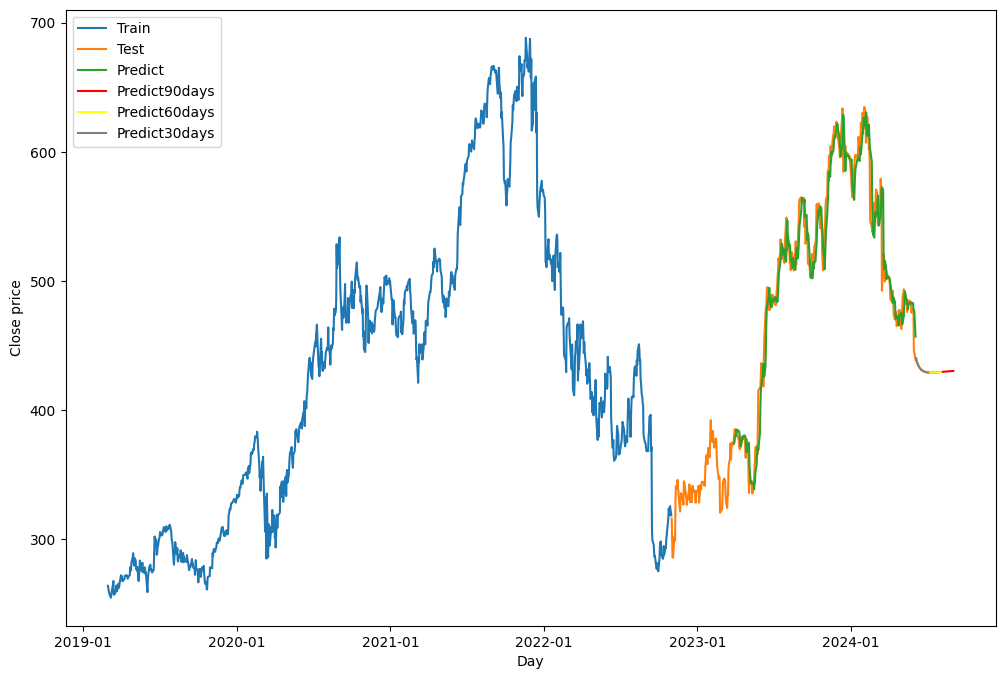

In [88]:
# 14.Vẽ hình
import matplotlib.dates as mdates
plt.figure(figsize=(12, 8))
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'][:train_size],scaler.inverse_transform(train_data))
plt.plot(df['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(df['Date'][train_size+101:],(y_pred))
predict_data_index_90 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Close price')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

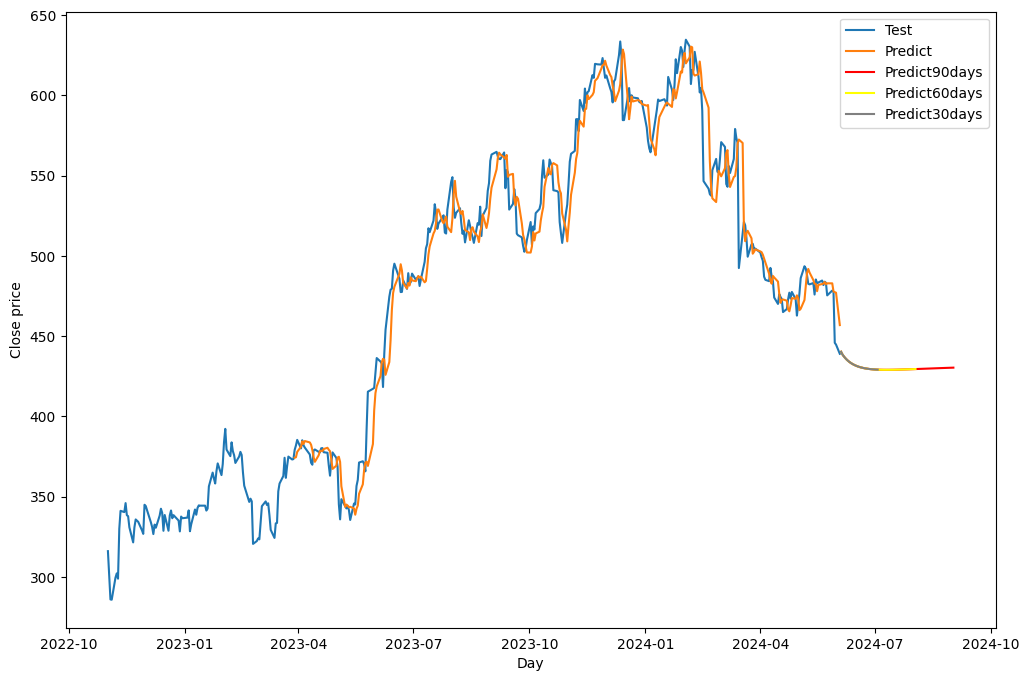

In [89]:
# 14.Vẽ hình test predict
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12,8))
plt.plot(df['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(df['Date'][train_size+101:],(y_pred))
predict_data_index_90 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=df['Date'][len(df['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Close price')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

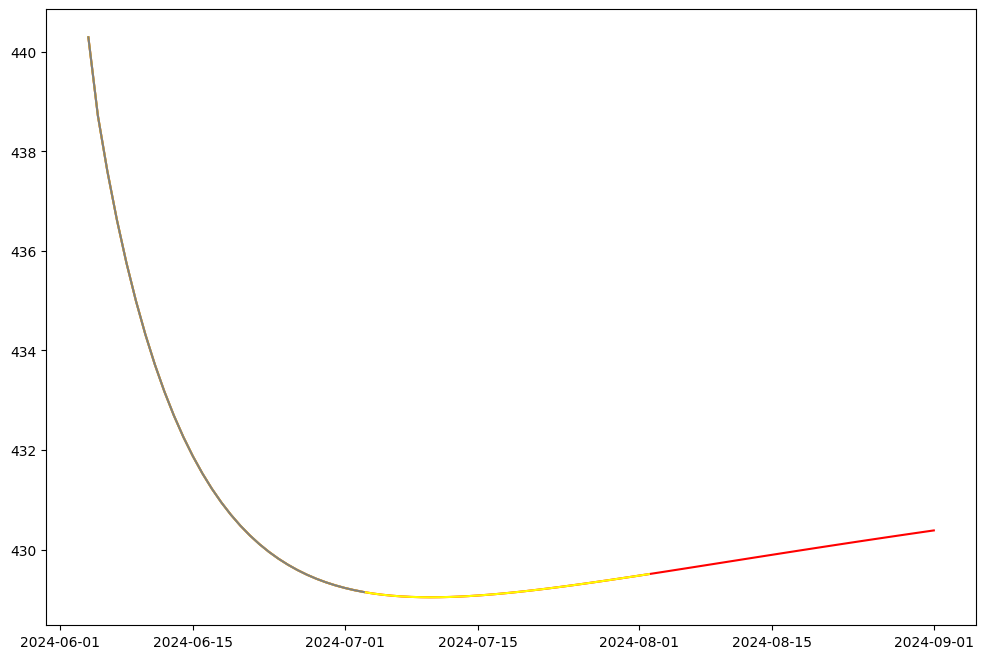

In [90]:
plt.figure(figsize=(12,8))
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.show()